## 3. Smoothing

Select an option:
1. Plot only
2. Plot and save
3. Save only


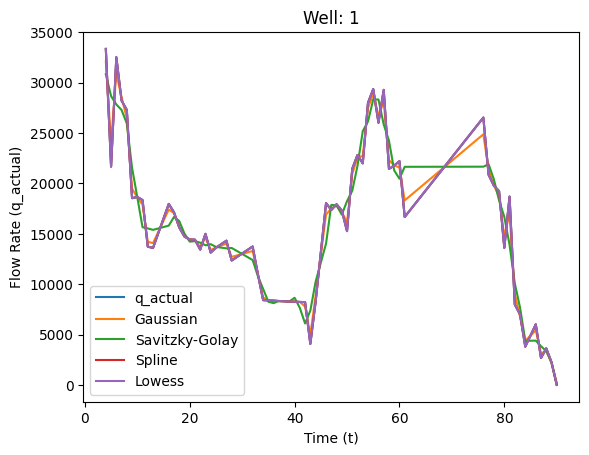

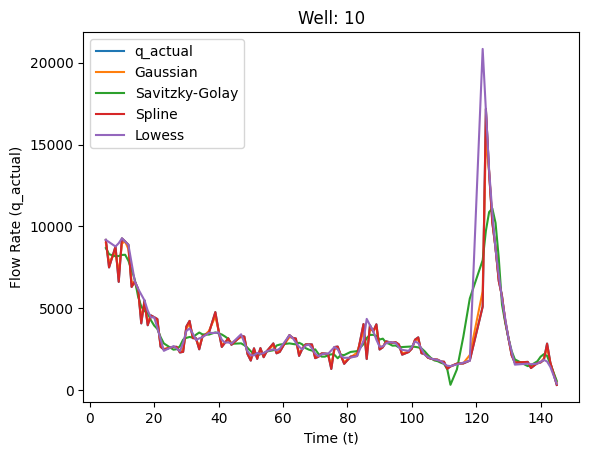

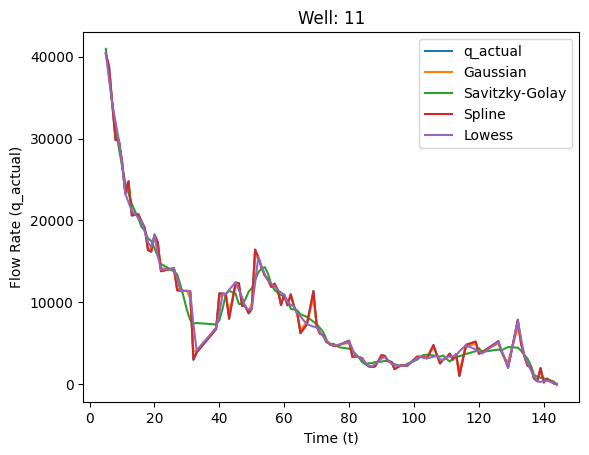

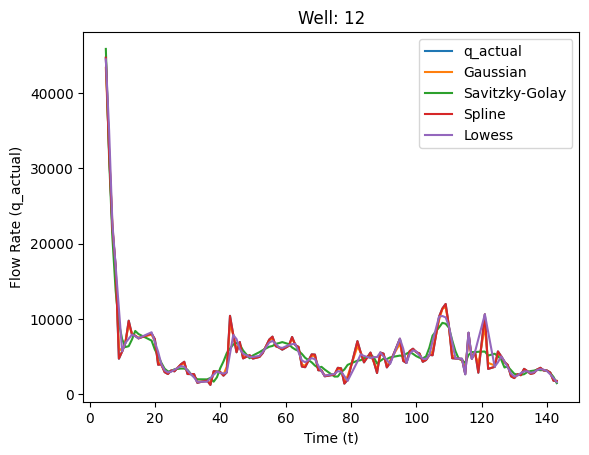

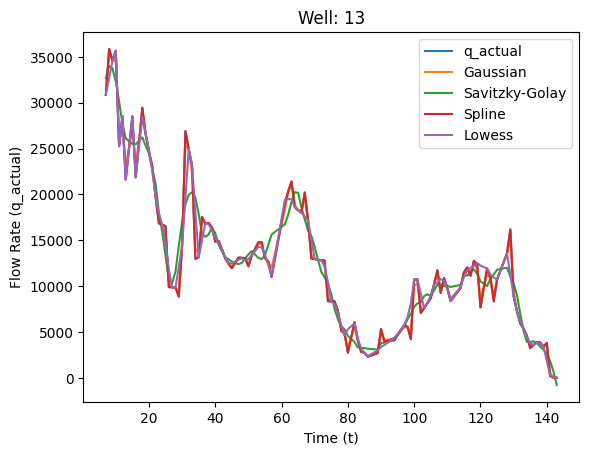

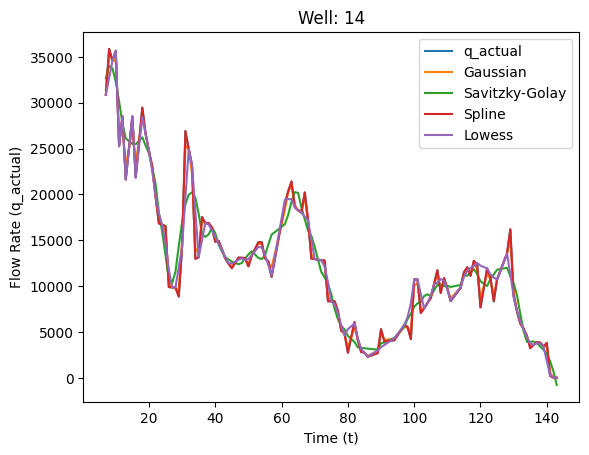

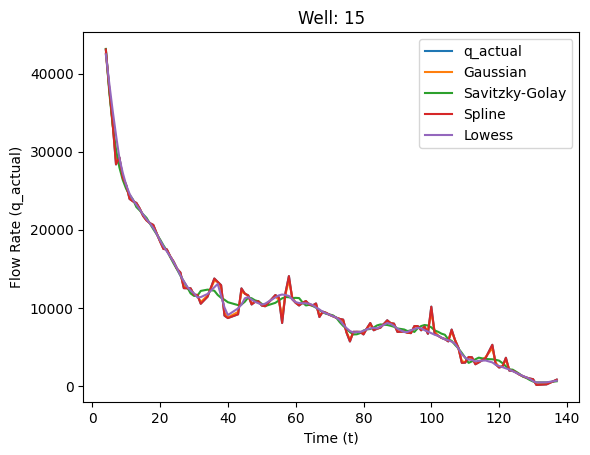

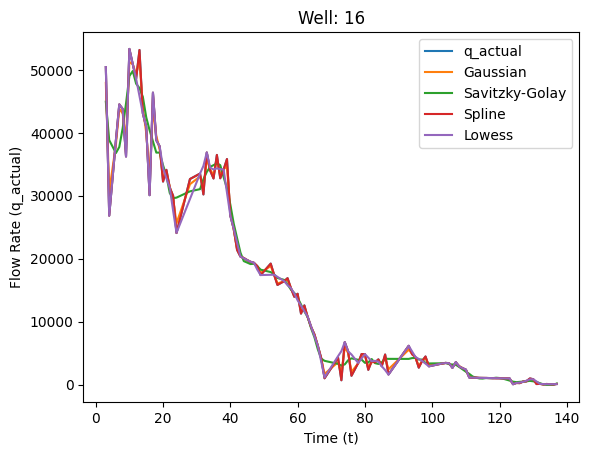

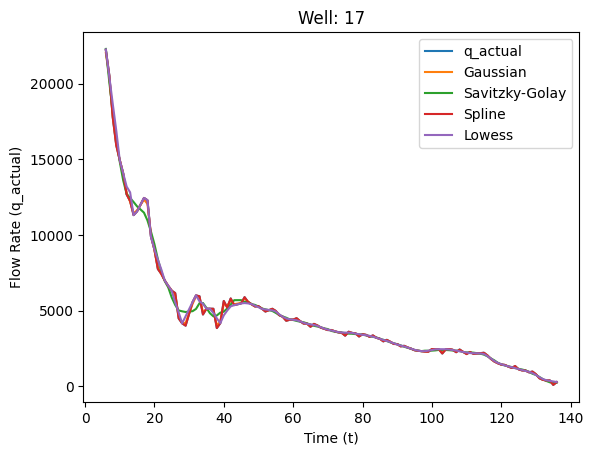

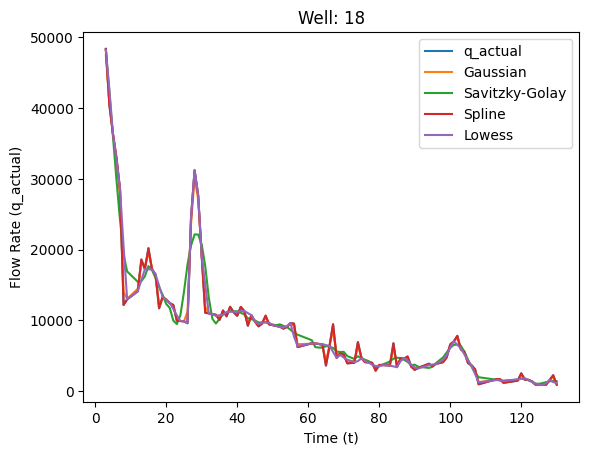

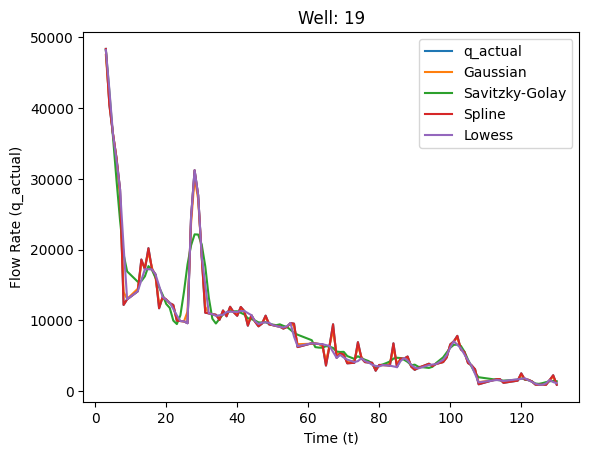

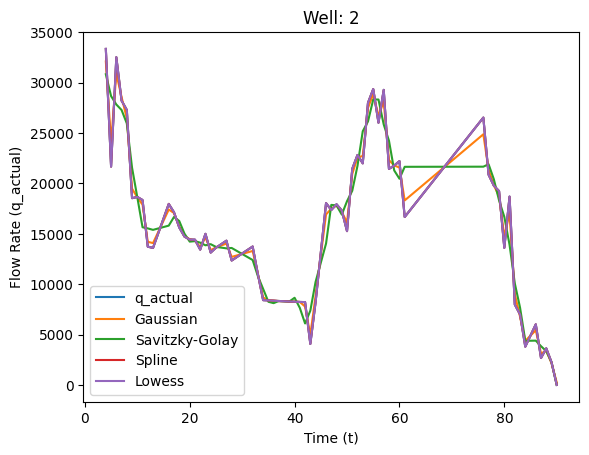

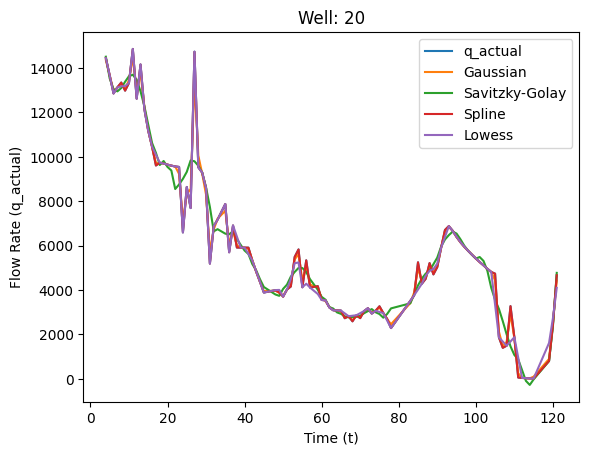

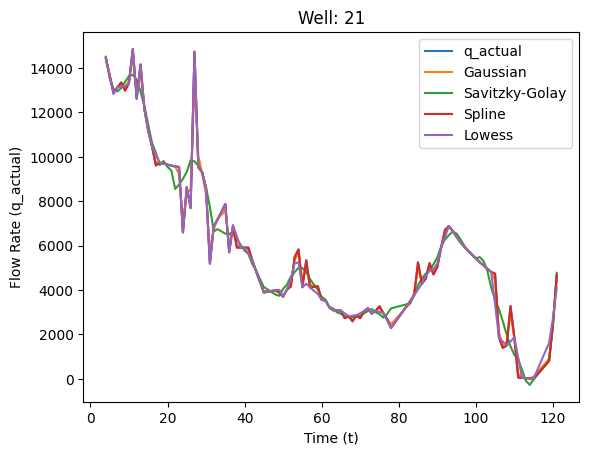

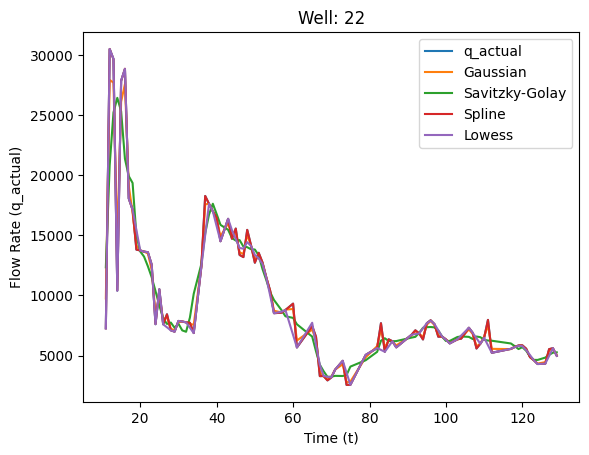

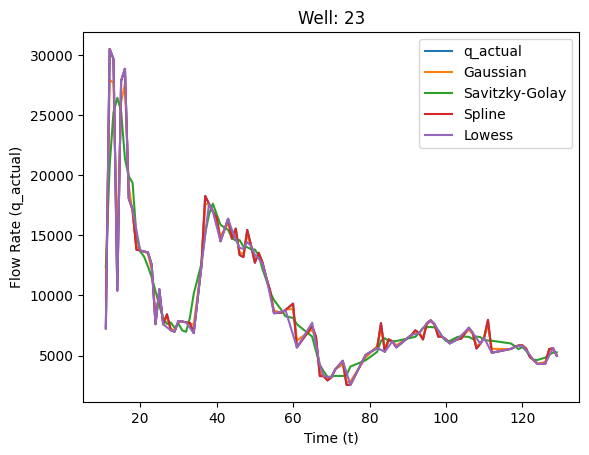

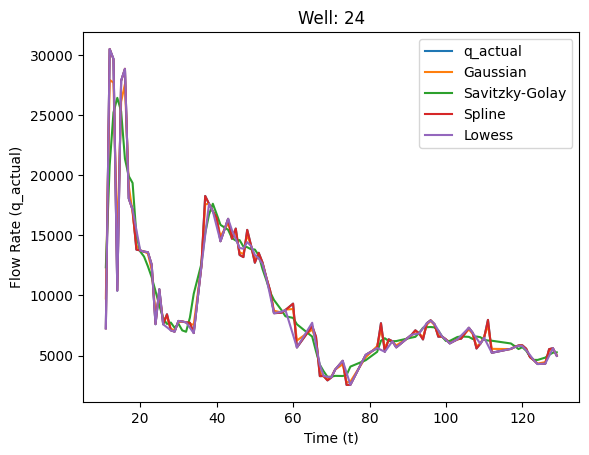

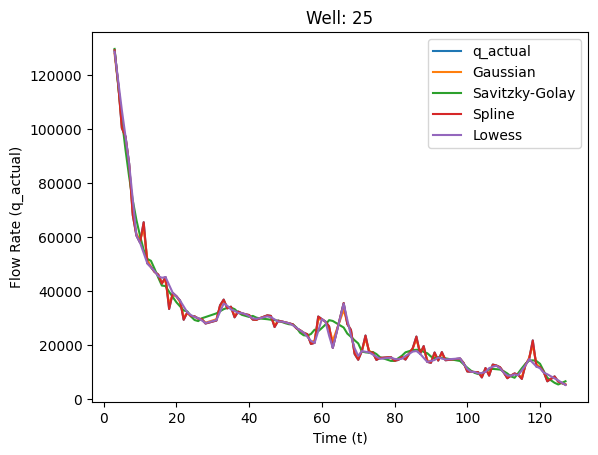

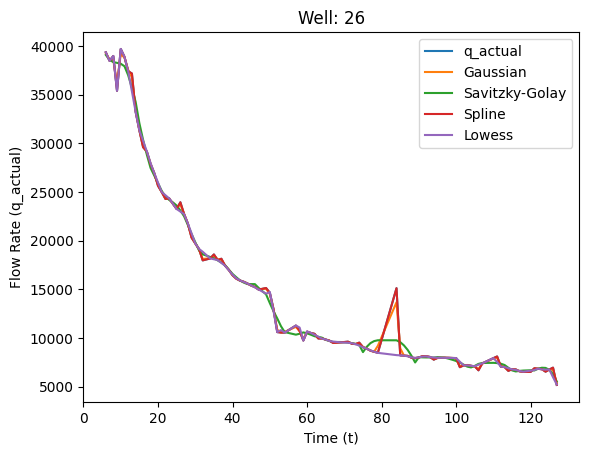

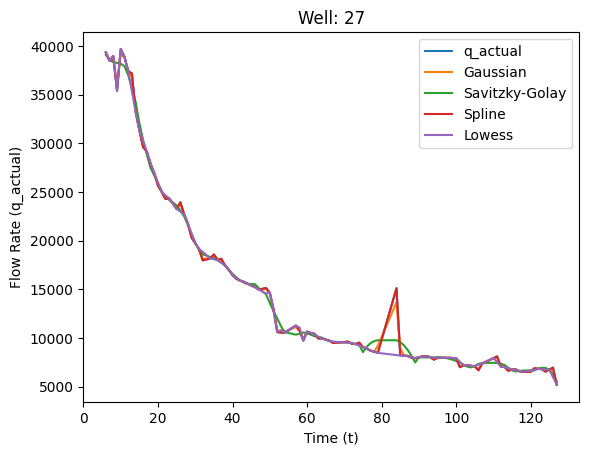

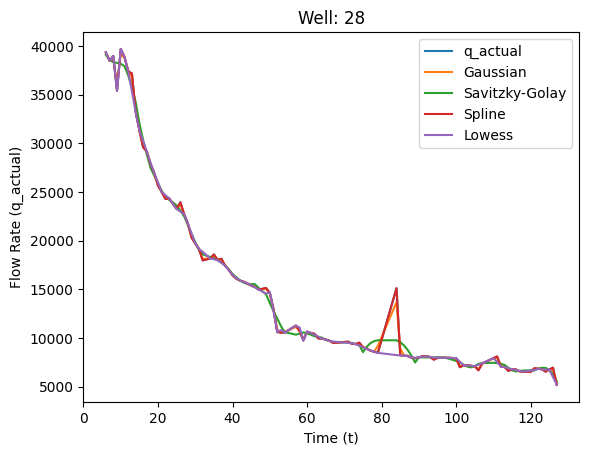

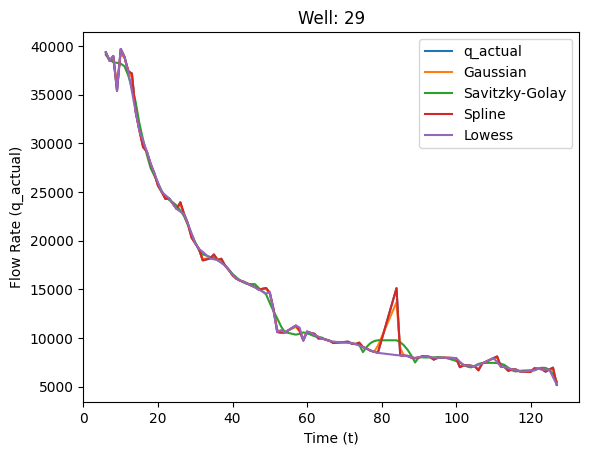

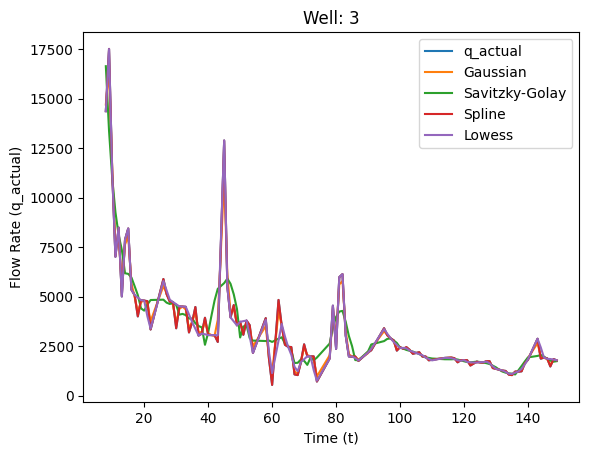

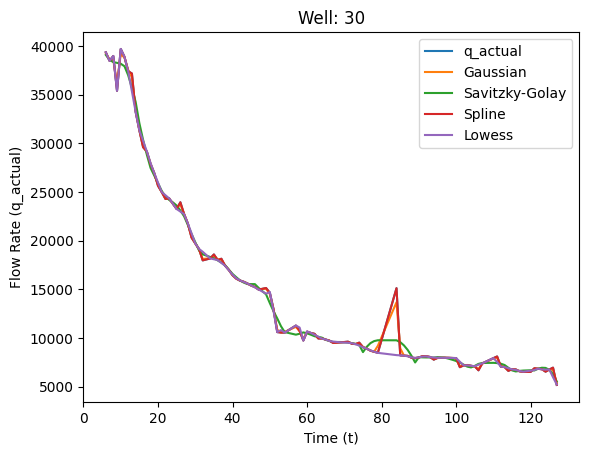

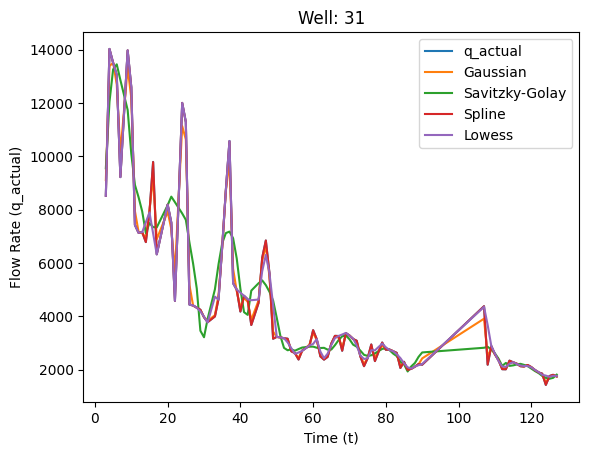

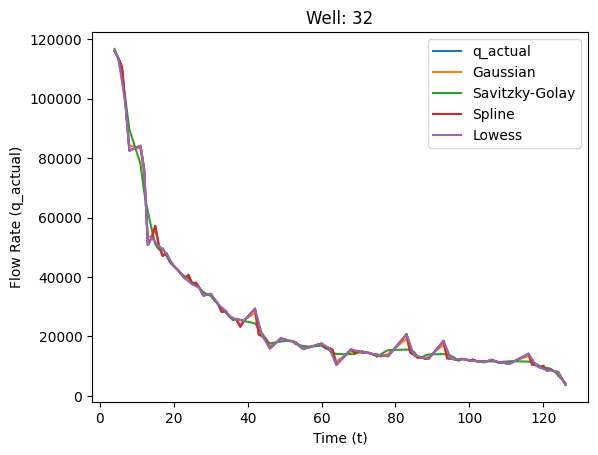

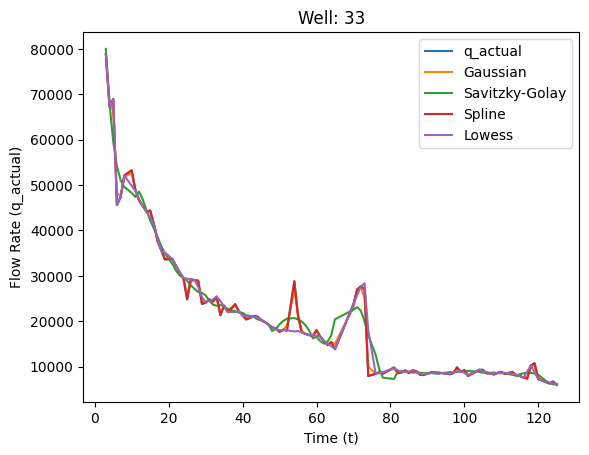

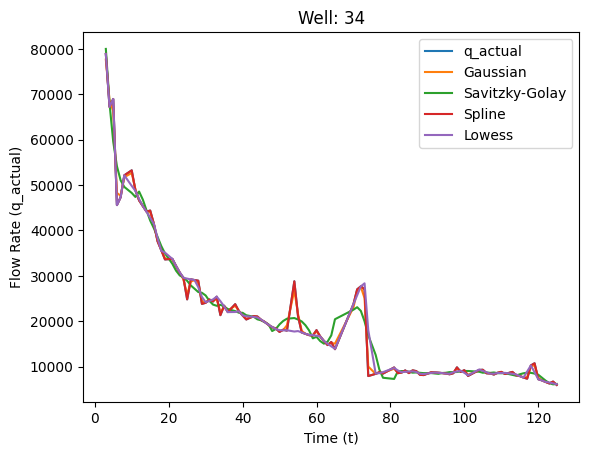

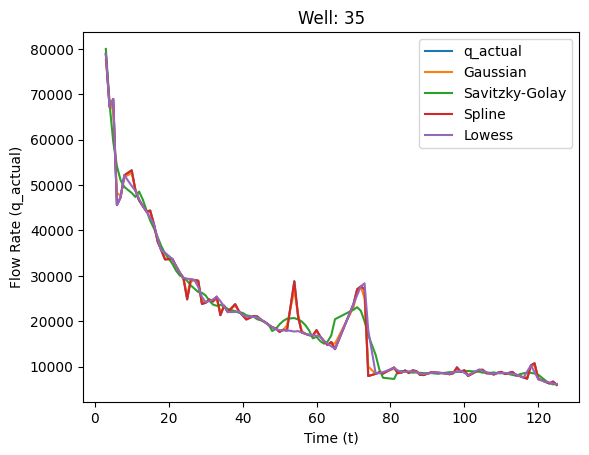

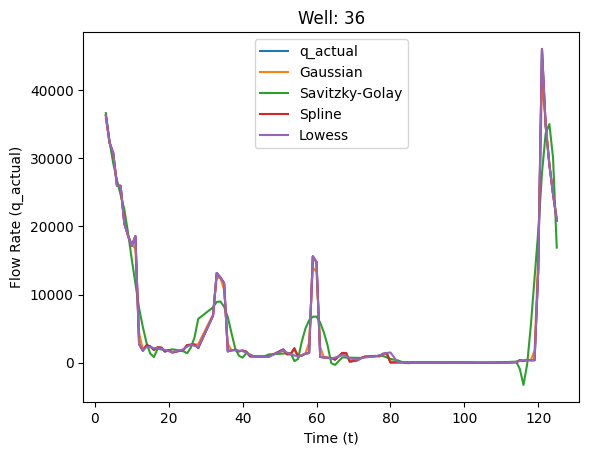

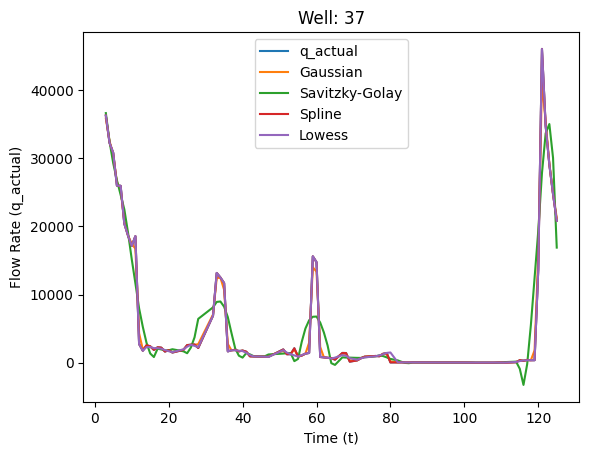

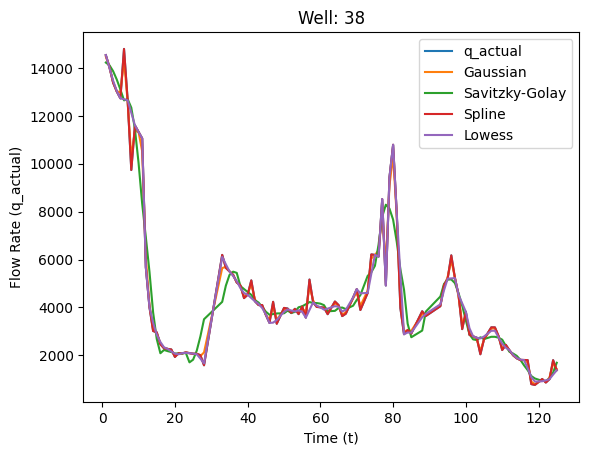

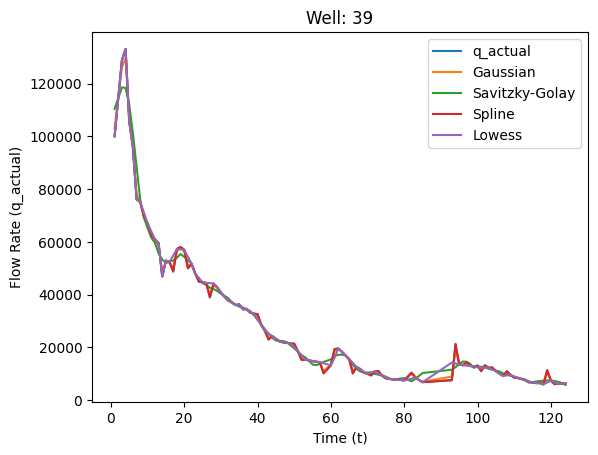

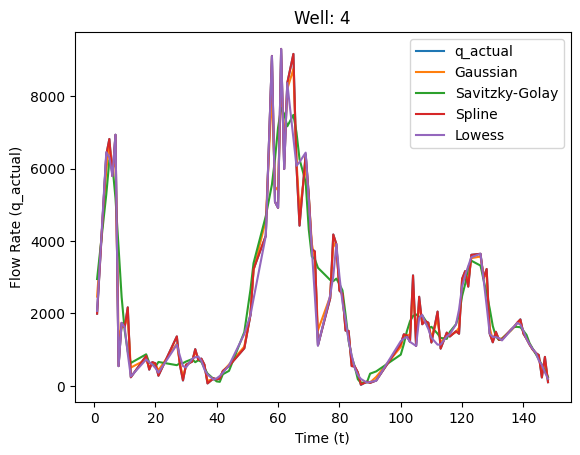

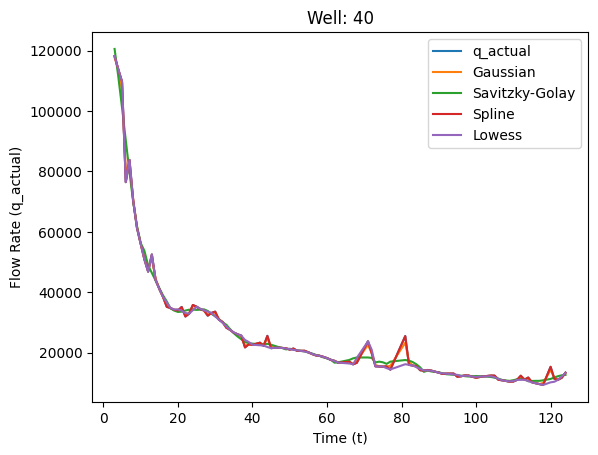

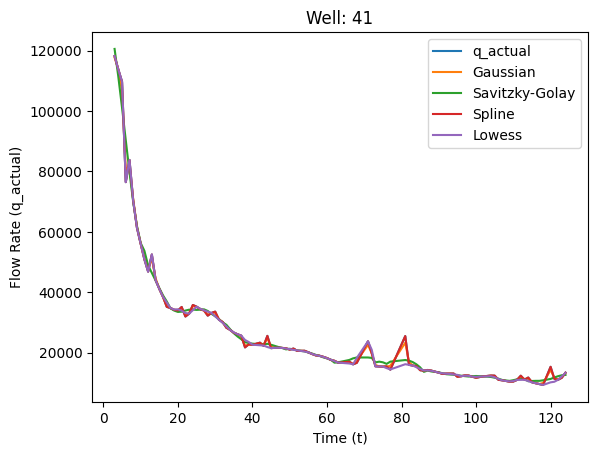

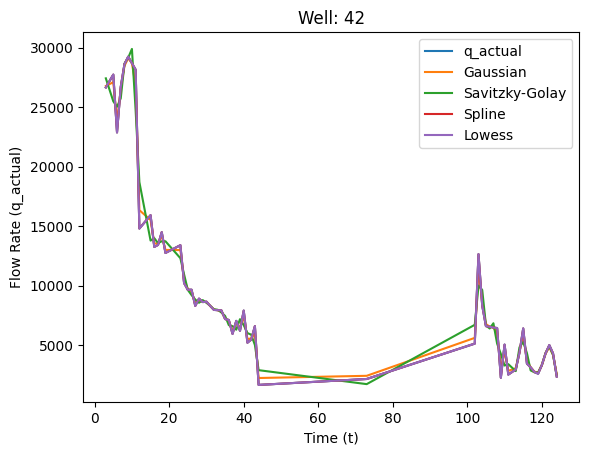

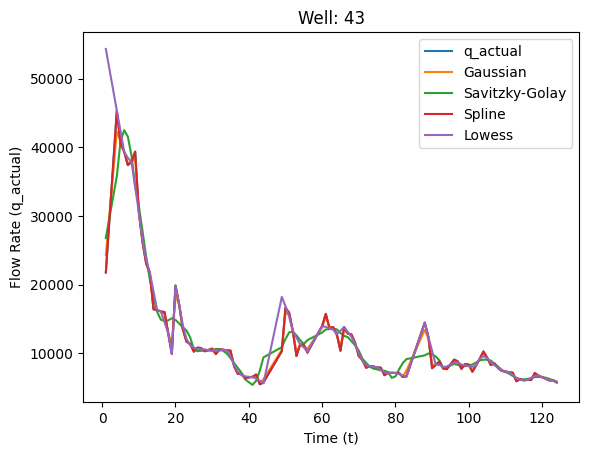

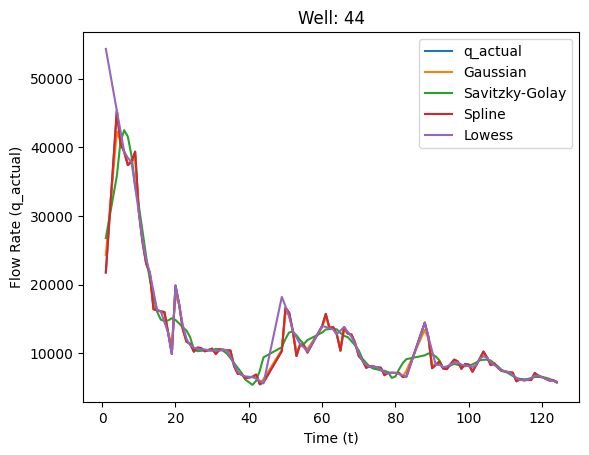

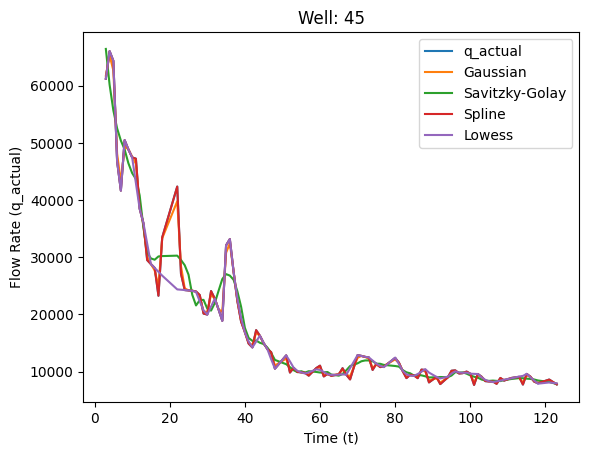

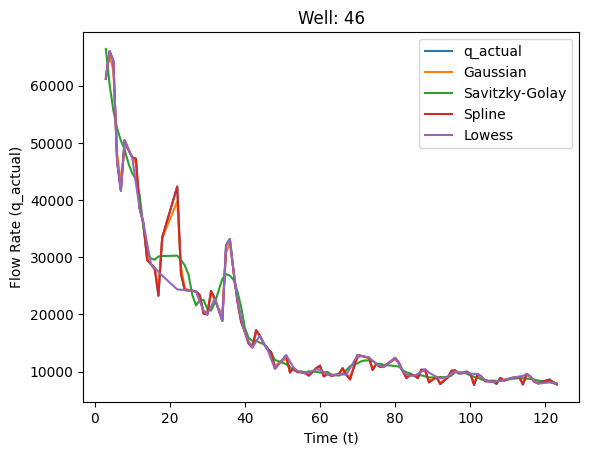

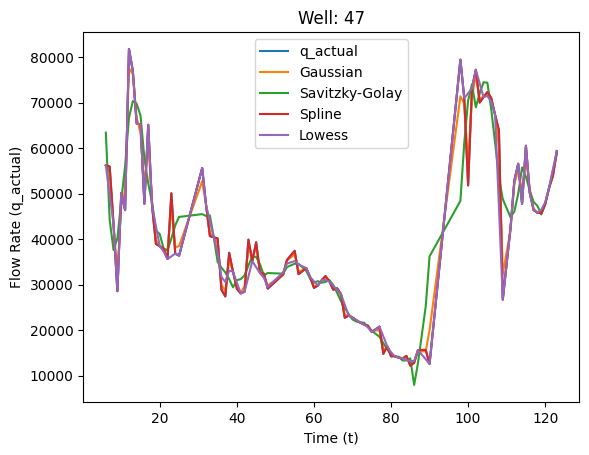

In [5]:
# This script processes CSV files from a specified directory to apply various smoothing filters to time-series data.
# The script supports user input to choose between plotting, saving, or both. It applies filters such as Gaussian, 
# Savitzky-Golay, Spline, and LOWESS, then saves or plots the results based on user preferences.

# Import necessary libraries
import numpy as np  # For numerical operations
import pandas as pd  # For data manipulation and analysis with DataFrames
from scipy.ndimage import gaussian_filter  # For Gaussian filtering
from scipy.signal import savgol_filter  # For Savitzky-Golay filtering
from scipy.interpolate import UnivariateSpline  # For spline smoothing
from statsmodels.nonparametric.smoothers_lowess import lowess  # For LOWESS smoothing
import os  # For interacting with the file system
import matplotlib.pyplot as plt  # For creating visualizations

# Function to process CSV files in a directory and apply smoothing filters
def process_and_smooth_csv_files(directory, option):
    """
    Processes CSV files in a directory and applies various smoothing filters to the data. Depending on the user's
    choice, the smoothed data can be plotted, saved, or both.

    Args:
    directory (str): The directory path containing CSV files to process.
    option (str): The user's choice for processing ('1' for plot only, '2' for plot and save, '3' for save only).

    Returns:
    None
    """
    # Nested function to apply various filters to the data
    def apply_filters(t, q_actual):
        """
        Applies multiple smoothing filters to the input data and returns a dictionary of the results.

        Args:
        t (np.ndarray): Time values from the data.
        q_actual (np.ndarray): Actual flow rate values from the data.

        Returns:
        dict: A dictionary containing filtered data for each applied smoothing method.
        """
        filters = {}  # Dictionary to store filtered data

        # Calculate data-driven parameters for filter configuration
        data_len = len(q_actual)  # Length of the data
        std_dev = np.std(q_actual)  # Standard deviation of the data
        q_range = np.max(q_actual) - np.min(q_actual)  # Range of the data

        # Apply Gaussian Filter
        sigma_gaussian = max(0.5, min(2, std_dev / q_range))  # Calculate Gaussian filter sigma
        filters['Gaussian'] = gaussian_filter(q_actual, sigma=sigma_gaussian)  # Apply Gaussian filter

        # Apply Savitzky-Golay Filter
        window_length_sg = max(5, min(11, (data_len // 10) | 1))  # Ensure window length is odd
        polyorder_sg = min(3, (window_length_sg - 1) // 2)  # Polynomial order for Savitzky-Golay
        if window_length_sg <= data_len:
            filters['Savitzky-Golay'] = savgol_filter(q_actual, window_length=window_length_sg, polyorder=polyorder_sg)  # Apply Savitzky-Golay filter
        else:
            filters['Savitzky-Golay'] = np.nan * np.ones_like(q_actual)  # Assign NaN if window length exceeds data length

        # Apply Spline Smoothing
        if data_len > 3:  # Ensure there are enough data points for spline fitting
            spline_s = std_dev * 0.5  # Spline smoothing parameter
            spline = UnivariateSpline(t, q_actual, s=spline_s)  # Fit spline to the data
            filters['Spline'] = spline(t)  # Evaluate spline
        else:
            filters['Spline'] = np.nan * np.ones_like(q_actual)  # Assign NaN if not enough data points

        # Apply LOWESS
        frac_lowess = max(0.05, min(0.3, 0.1 * std_dev / q_range))  # Calculate LOWESS fraction
        lowess_filtered = lowess(q_actual, t, frac=frac_lowess)  # Apply LOWESS filter
        filters['Lowess'] = np.array([point[1] for point in lowess_filtered])  # Extract LOWESS values

        return filters  # Return dictionary of filtered data

    keywords = ['interpolated']  # Keywords to identify files to process

    # Iterate over files in the directory
    for filename in os.listdir(directory):
        # Check if the file is a CSV and matches one of the keywords
        if filename.endswith(".csv") and any(keyword in filename for keyword in keywords):
            file_path = os.path.join(directory, filename)  # Full path of the file
            data = pd.read_csv(file_path)  # Read CSV file into a DataFrame

            # Check if the file has the necessary columns
            if 't' not in data.columns or data.shape[1] < 2:
                print(f"File {filename} does not have the necessary columns for processing.")
                continue

            t = data['t'].values  # Extract time values
            q_actual = data.iloc[:, 1].values  # Extract actual flow rate values

            filters = apply_filters(t, q_actual)  # Apply filters to the data

            # Add filtered data to the DataFrame
            for filter_name, filtered_data in filters.items():
                # Ensure the length of the filtered data matches the original data length
                filtered_series = pd.Series(filtered_data[:len(data)], index=data.index[:len(filtered_data)])
                data[filter_name] = filtered_series  # Add filtered data as a new column

            # Identify the type of cleaning used based on keywords
            for keyword in keywords:
                if keyword in filename:
                    clean_type = keyword  # Determine cleaning type
                    break

            # Save the DataFrame with smoothed data to a new CSV file if selected by the user
            if option in ['2', '3']:
                output_file_path = os.path.join(directory, f"smoothed_{clean_type}_{filename}")  # Create output file path
                data.to_csv(output_file_path, index=False)  # Save smoothed data to CSV
                print(f"Processed and saved smoothed data: {output_file_path}")

            # Plot the smoothed data if selected by the user
            if option in ['1', '2']:
                plot_smoothed_data(data, filename, t)  # Plot smoothed data

# Function to plot the smoothed data
def plot_smoothed_data(data, filename, t):
    """
    Plots the smoothed data from the given DataFrame.

    Args:
    data (pd.DataFrame): The DataFrame containing original and smoothed data.
    filename (str): The name of the file being processed, used for plot title.
    t (np.ndarray): The time values corresponding to the data.

    Returns:
    None
    """
    #q_actual = data.iloc[:, 1].values # Extract actual flow rate data

    #plt.figure(figsize=(12, 6))  # Set figure size

    # Plot q_actual
    #plt.plot(t, q_actual, label='Actual', color='black', linestyle='--')  # Plot actual data with a dashed line

    data_columns = data.columns[1:]  # Exclude 't' and 'q_actual' columns
    for column in data_columns:
        plt.plot(t, data[column].iloc[:len(t)], label=column)  # Plot each smoothed data column

    well_name = filename.split('.')[0]  # Extract well name from filename
    plt.title(f"Well: {well_name}")  # Set plot title
    plt.xlabel('Time (t)')  # Label x-axis
    plt.ylabel('Flow Rate (q_actual)')  # Label y-axis
    plt.legend()  # Show legend
    plt.show()  # Display plot

# Main function to handle user input
def main():
    """
    The main function to handle user input and process the CSV files.

    Prompts:
    User input for directory path and processing choice.

    Workflow:
    1. Prompt user for directory path containing CSV files.
    2. Display options for processing: plot only, plot and save, or save only.
    3. Process files based on user choice.

    Returns:
    None
    """
    directory = input("Enter the directory path: ")  # Prompt user for directory path
    print("Select an option:")
    print("1. Plot only")
    print("2. Plot and save")
    print("3. Save only")
    choice = input("Enter your choice (1/2/3): ")  # Prompt user for choice
    
    # Process files based on user choice
    if choice in ['1', '2', '3']:
        process_and_smooth_csv_files(directory, choice)  # Process and smooth CSV files
    else:
        print("Invalid choice. Please select 1, 2, or 3.")  # Handle invalid choice

# Run the main function
if __name__ == "__main__":
    main()  # Entry point of the script
